In [ ]:
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post5-py3-none-any.whl size=2950 sha256=a1b0e0ca8cf2650da7052165a7828f82d4ed094c7f655f489e57b3ea90d131ee
  Stored in directory: /root/.cache/pip/wheels/38/1f/8d/4f812c590e074c1e928f5cec67bf5053b71f38e2648739403a
Successfully built sklearn


In [2]:
import sklearn
import scipy, itertools
import numpy as np

def L2_of_gmms(gmm1, gmm2):

  firstterm = np.sum([ai * aj * scipy.stats.multivariate_normal.pdf(meani - meanj, cov = covi + covj) for (ai, meani, covi),(aj, meanj, covj) in itertools.product(zip(gmm1.weights_,gmm1.means_,gmm1.covariances_),zip(gmm1.weights_,gmm1.means_,gmm1.covariances_))])
  secondterm = np.sum([ai * aj * scipy.stats.multivariate_normal.pdf(meani - meanj, cov = covi + covj) for (ai, meani, covi),(aj, meanj, covj) in itertools.product(zip(gmm2.weights_,gmm2.means_,gmm2.covariances_),zip(gmm2.weights_,gmm2.means_,gmm2.covariances_))])
  thirdterm = np.sum([ai * aj * scipy.stats.multivariate_normal.pdf(meani - meanj, cov = covi + covj) for (ai, meani, covi),(aj, meanj, covj) in itertools.product(zip(gmm1.weights_,gmm1.means_,gmm1.covariances_),zip(gmm2.weights_,gmm2.means_,gmm2.covariances_))])

  return firstterm + secondterm - 2 * thirdterm

0


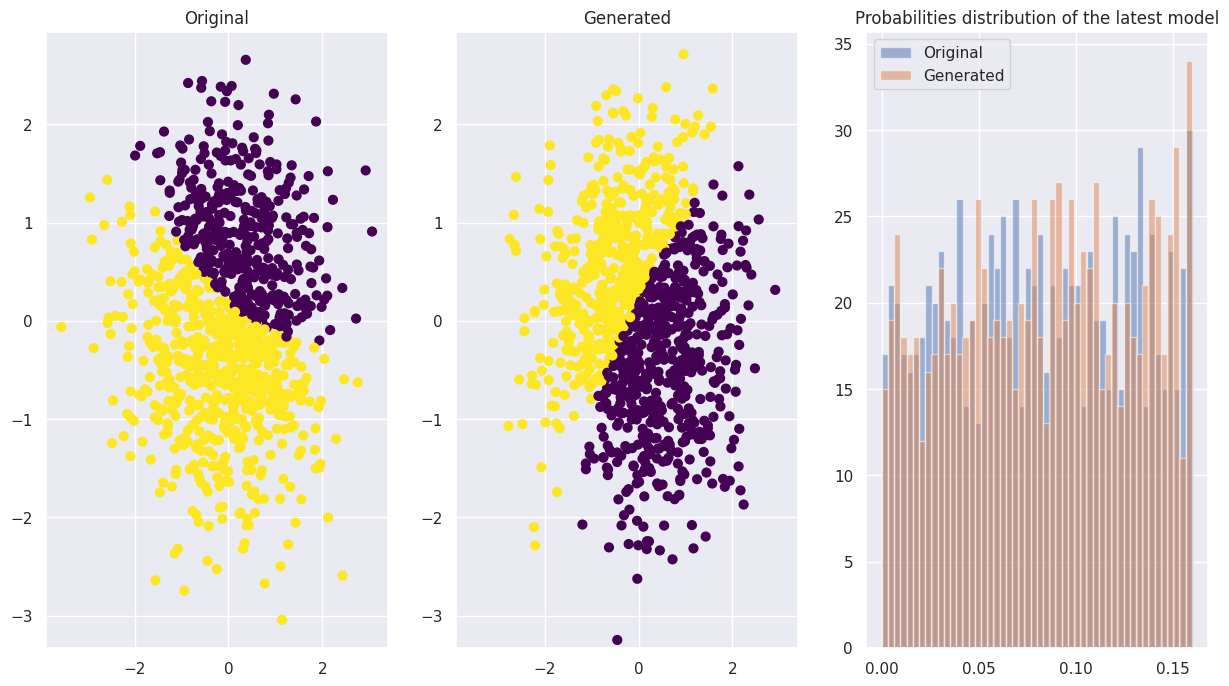

50


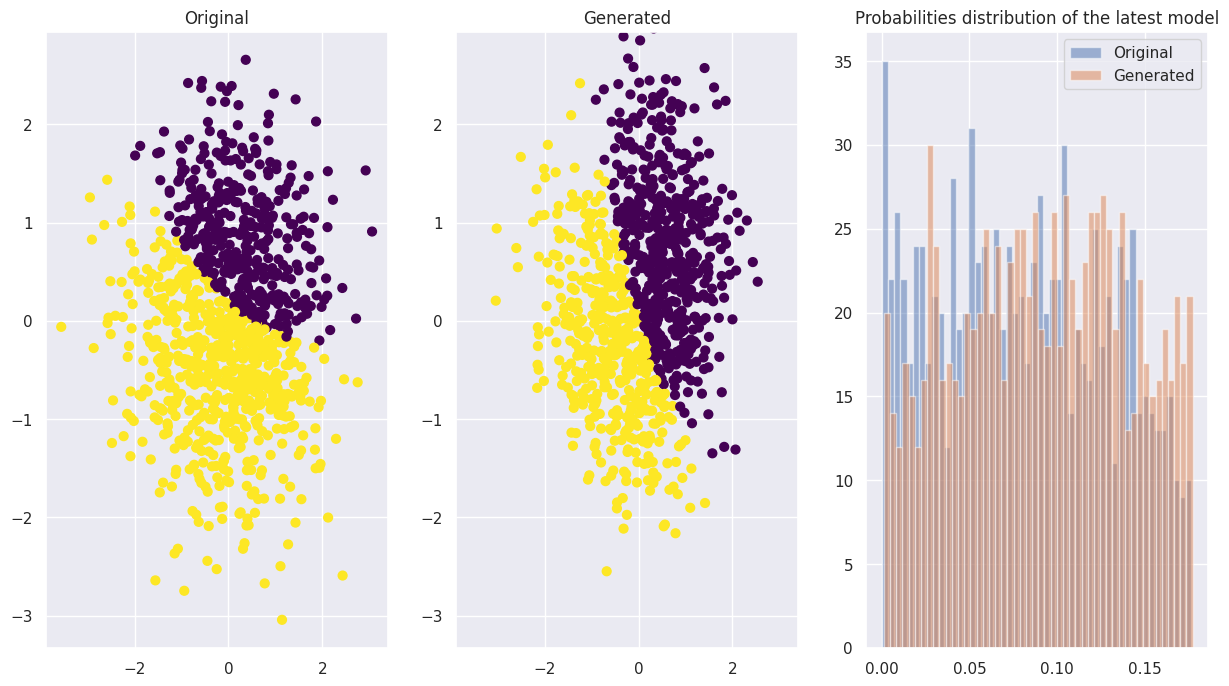

100


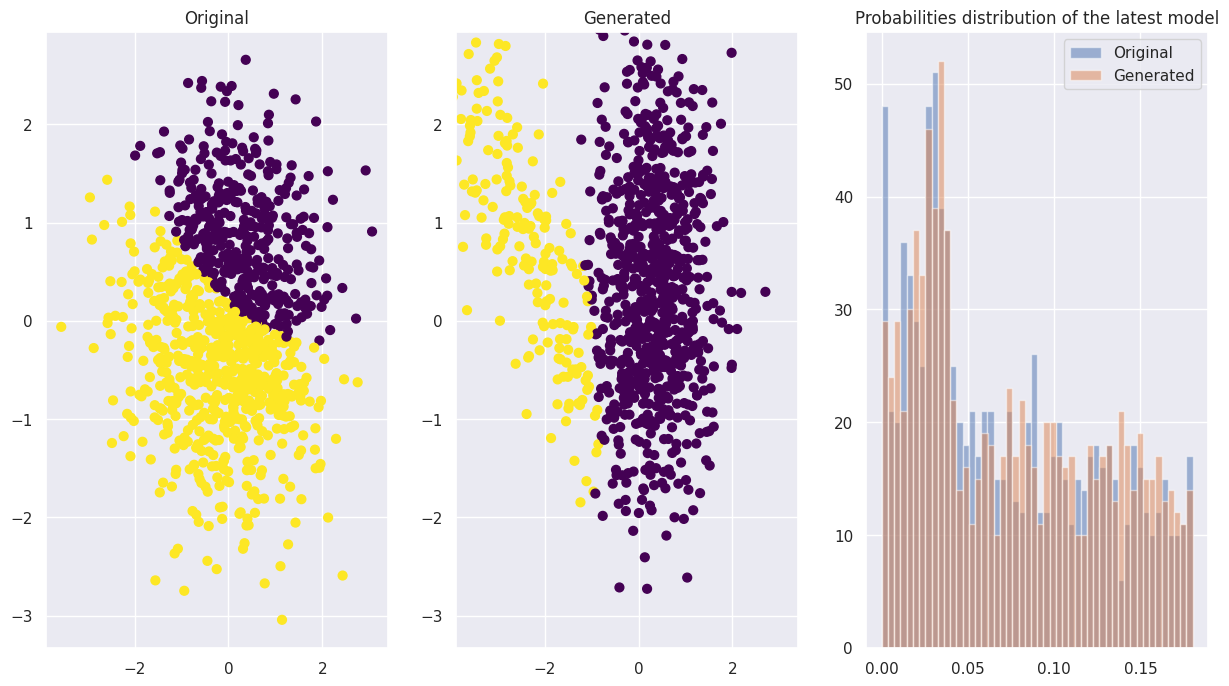

150


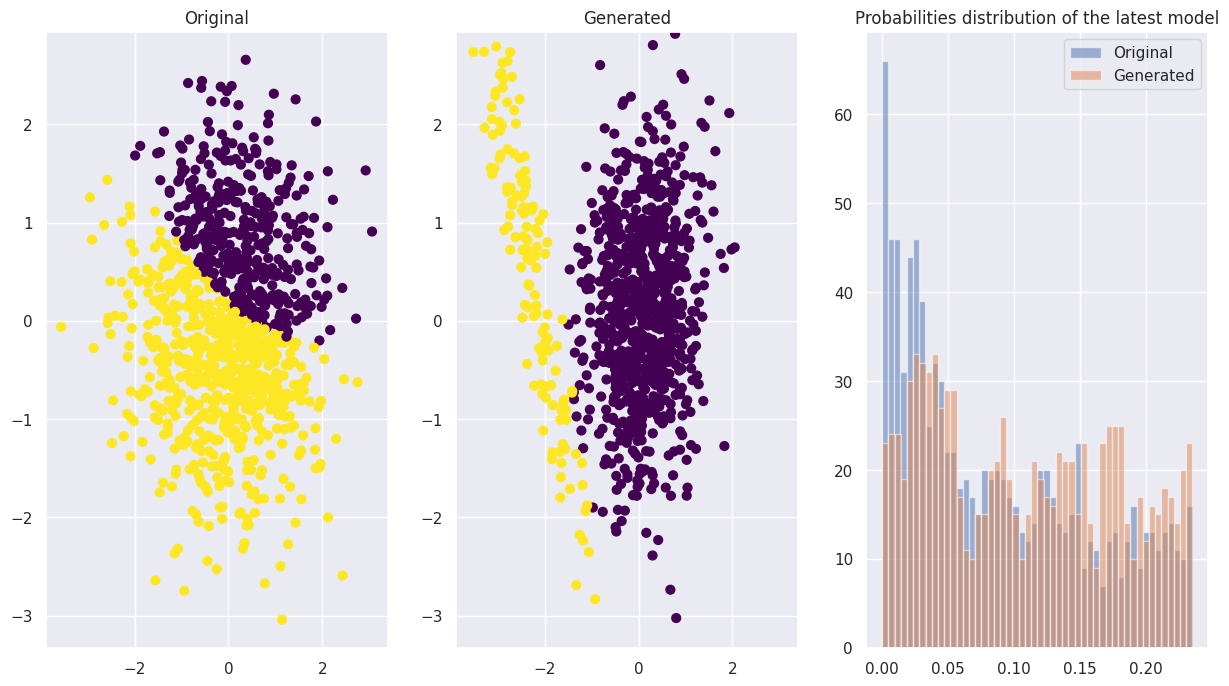

200


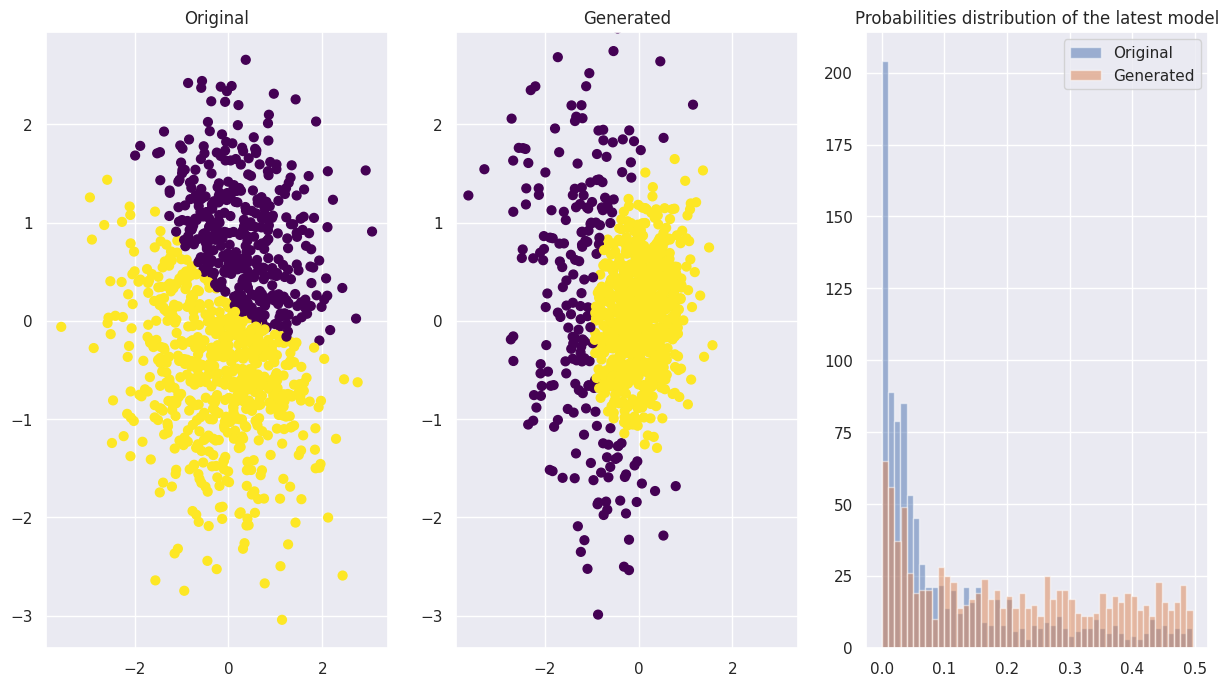

350


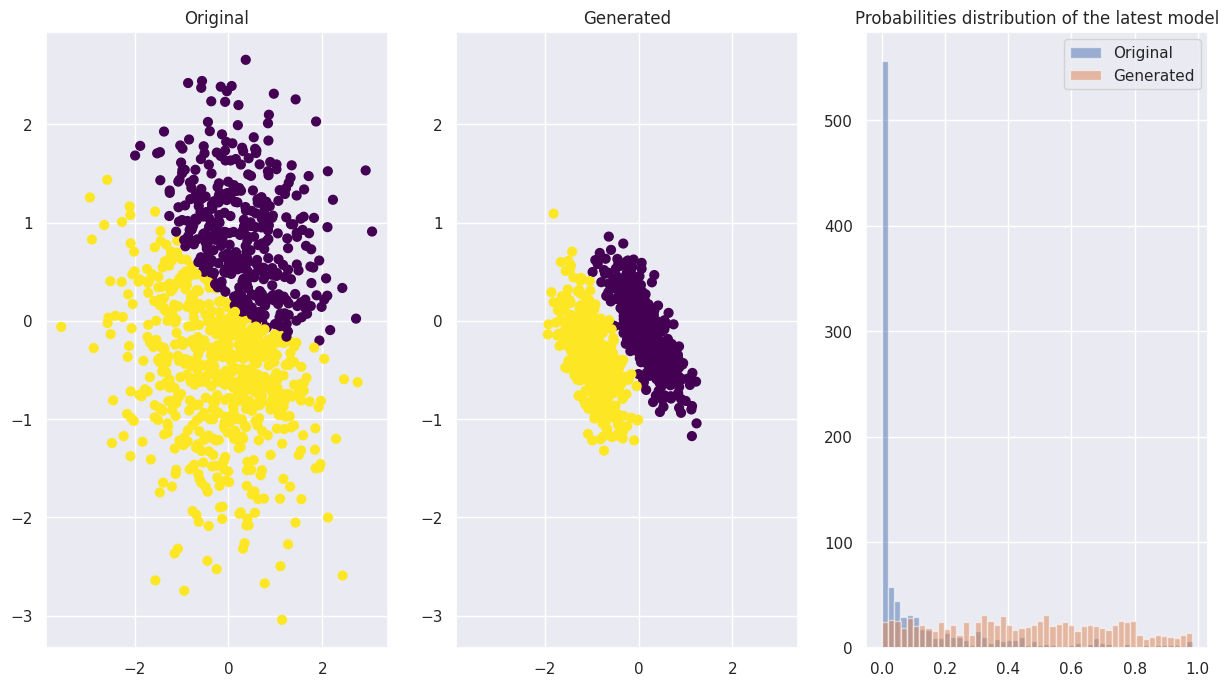

2000


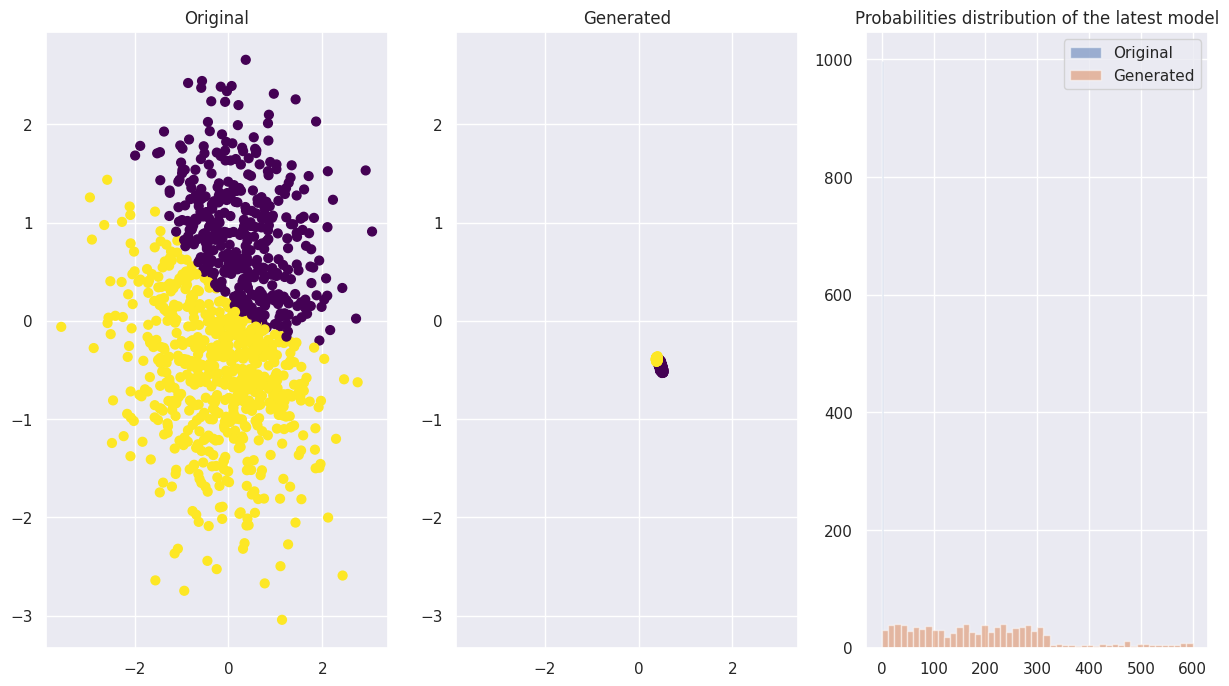

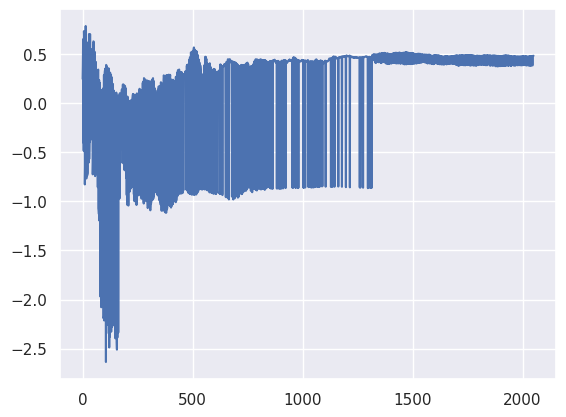

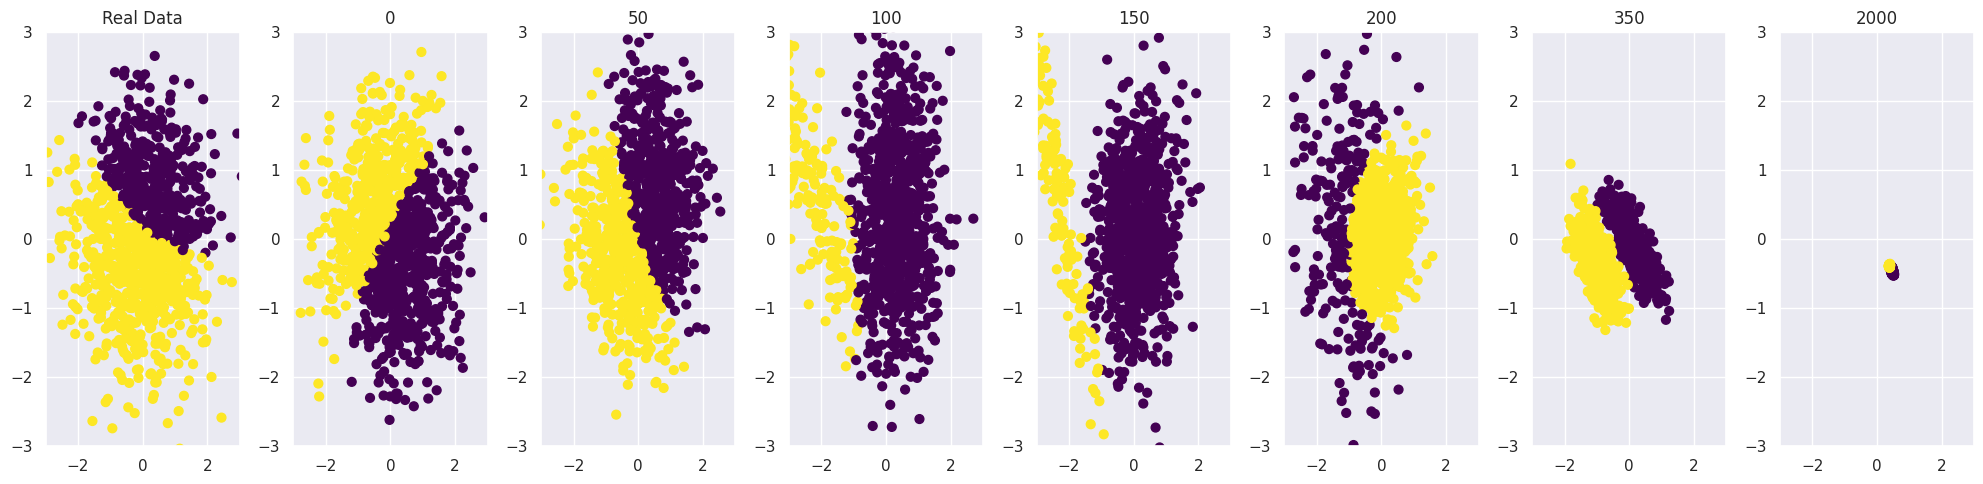

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
from sklearn.datasets import make_blobs
import random

mms = []
ssds = []
vars = [1, ]

ncomponents = 2
gmmparams = {"n_components": ncomponents, "tol": 1e-5, "covariance_type": "full", "max_iter": 2000}

scatters = []
l2s = []
ns = [1000]# [500, 1000, 10000, 50000, 200000]

for var in vars:
  for N in ns:

    # ncomponents
    X, y_true = make_blobs(n_samples=N, n_features=1, centers=[[0,0]], cluster_std=var)

    X0_orig = X[:, ::-1] # flip axes for better plotting
    X_0_gmm = GMM(**gmmparams).fit(X0_orig)
    labels_orig = X_0_gmm.predict(X0_orig)

    X0 = X0_orig[:]
    X = X0[:]


    means = [(X_0_gmm.means_[:].flatten())]
    if gmmparams["covariance_type"]!="diag":
      stds = [([ np.sqrt(  np.trace(X_0_gmm.covariances_[i])/ncomponents) for i in range(0,ncomponents) ])]
    else:
      stds = [X_0_gmm.covariances_]

    # print(means, np.mean(X, axis=1))
    # print(stds,  np.std(X, axis=1))
    evolutions = 2050
    for m in range(evolutions):
      # if m == 0:
        # combined = X0
      # else:
      #   combined = np.vstack([X, X0])
      gmm = GMM(**gmmparams).fit(X)
      
      

      # toadd = random.sample(X0.tolist(), int(len(X0)*1.))
      # X0 = np.vstack([toadd, X0])
      X = gmm.sample(N)[0]

      
      # X = np.vstack([toadd, X])
      l2s.append(L2_of_gmms(X_0_gmm,gmm))
      means.append((gmm.means_[:].flatten()))

      if gmmparams["covariance_type"] != "diag":
        stds.append(([ np.sqrt(  np.trace(gmm.covariances_[i])/ncomponents) for i in range(0,ncomponents) ]))
      else:
        stds.append(gmm.covariances_)
      
      probs_original = np.exp(gmm.score_samples(X0))
      probs_generated = np.exp(gmm.score_samples(X))

      if m in [0, 50, 100, 150, 200, 350, 2000]:
        print(m)
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 8))
        ax[0].scatter(X0_orig[:, 0], X0_orig[:, 1], c=labels_orig, s=40, cmap='viridis');
        ax[0].set_title("Original")
        test = X
        labels = gmm.predict(test)

        scatters.append((test[:,0], test[:, 1], m, labels))
        ax[1].scatter(test[:, 0], test[:, 1], c=labels, s=40, cmap='viridis');
        ax[1].set_ylim(ax[0].get_ylim())
        ax[1].set_xlim(ax[0].get_xlim())
        ax[1].set_title("Generated")
        
        
        ax[2].hist(probs_original, bins=50, alpha=0.5, label='Original')
        ax[2].hist(probs_generated, bins=50, alpha=0.5, label='Generated')
        ax[2].legend()
        ax[2].set_title("Probabilities distribution of the latest model")

        # probs_original = np.exp(X_0_gmm.score_samples(X0))
        # probs_generated = np.exp(X_0_gmm.score_samples(X))
        # ax[3].hist(probs_original, bins=50, alpha=0.5, label='Original')
        # ax[3].hist(probs_generated, bins=50, alpha=0.5, label='Generated')
        # ax[3].legend()
        # ax[3].set_title("Probabilities distribution of the first model")

        # probs_original = gmm.predict_proba(X0)
        # probs_generated = gmm.predict_proba(X)
        # ax[3].hist(probs_original[:, 0], bins=50, alpha=0.5, label='Original')
        # ax[3].hist(probs_generated[:, 0], bins=50, alpha=0.5, label='Generated')
        # ax[3].legend()
        # ax[3].set_title("Probabilities distribution of samples belonging to the first component")
  
        # probs_original = gmm.predict_proba(X0)
        # probs_generated = gmm.predict_proba(X)
        # ax[4].hist(probs_original[:, 1], bins=50, alpha=0.5, label='Original')
        # ax[4].hist(probs_generated[:, 1], bins=50, alpha=0.5, label='Generated')
        # ax[4].legend()
        # ax[4].set_title("Probabilities distribution of samples belonging to the second component")
        plt.show()
    print()

    # Removing all samples with scores in the upper 80 percentile
    toremove = np.where(probs_generated > np.percentile(probs_generated, 80))[0]
    X = np.delete(X, toremove, axis=0)

    mms.append(means)
    ssds.append(stds)

    # labels = gmm.predict(X)
    # ax[1].scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')

    plt.figure()
    plt.plot([x[0] for x in means])

fig, ax = plt.subplots(nrows=1, ncols=len(scatters)+1, figsize=(20, 5))
ax[0].scatter(X0_orig[:, 0], X0_orig[:, 1], c=labels_orig, s=40, cmap='viridis')
ax[0].set_title("Real Data")
ax[0].set_ylim([-3,3])
ax[0].set_xlim([-3,3])

for i, (scatx, scaty, epoch, labels) in enumerate(scatters):
  ax[i+1].scatter(scatx, scaty, c=labels, s=40, cmap='viridis')
  ax[i+1].set_title(f"{epoch}")
  ax[i+1].set_ylim(ax[0].get_ylim())
  ax[i+1].set_xlim(ax[0].get_xlim())

plt.tight_layout()

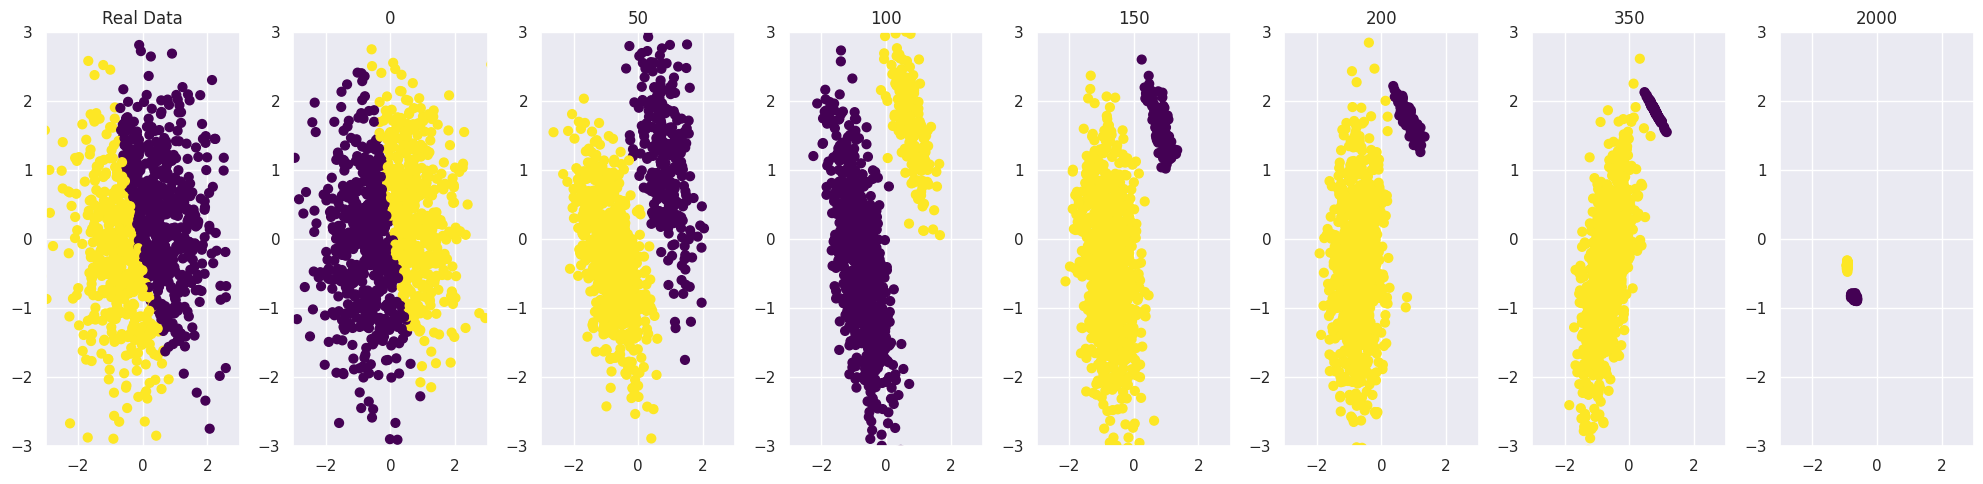

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=len(scatters)+1, figsize=(20, 5))
ax[0].scatter(X0_orig[:, 0], X0_orig[:, 1], c=labels_orig, s=40, cmap='viridis')
ax[0].set_title("Real Data")
ax[0].set_ylim([-3,3])
ax[0].set_xlim([-3,3])

for i, (scatx, scaty, epoch, labels) in enumerate(scatters):
  ax[i+1].scatter(scatx, scaty, c=labels, s=40, cmap='viridis')
  ax[i+1].set_title(f"{epoch}")
  ax[i+1].set_ylim(ax[0].get_ylim())
  ax[i+1].set_xlim(ax[0].get_xlim())

plt.tight_layout()

0


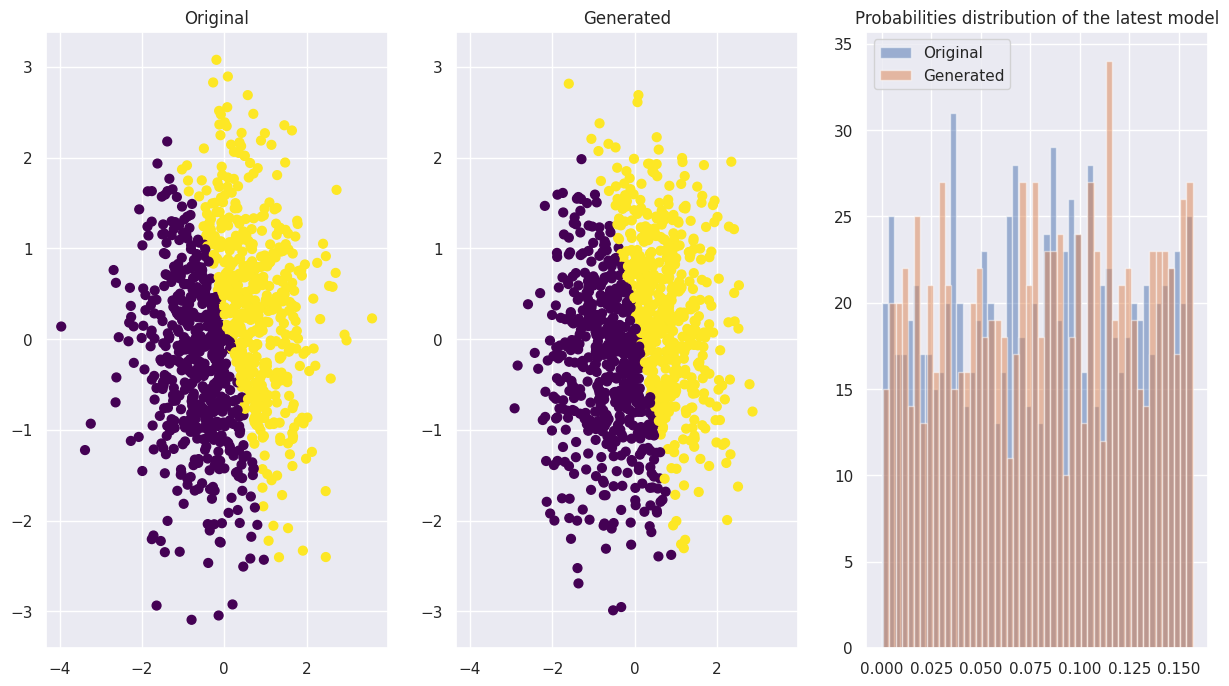

50


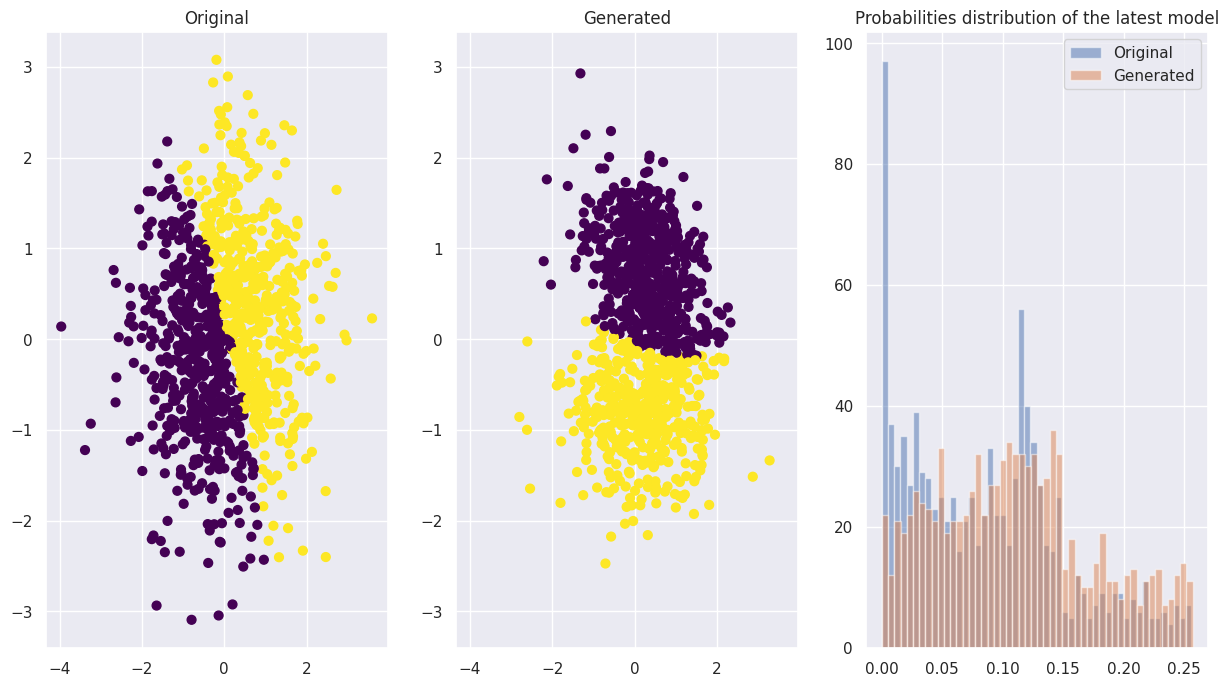

100


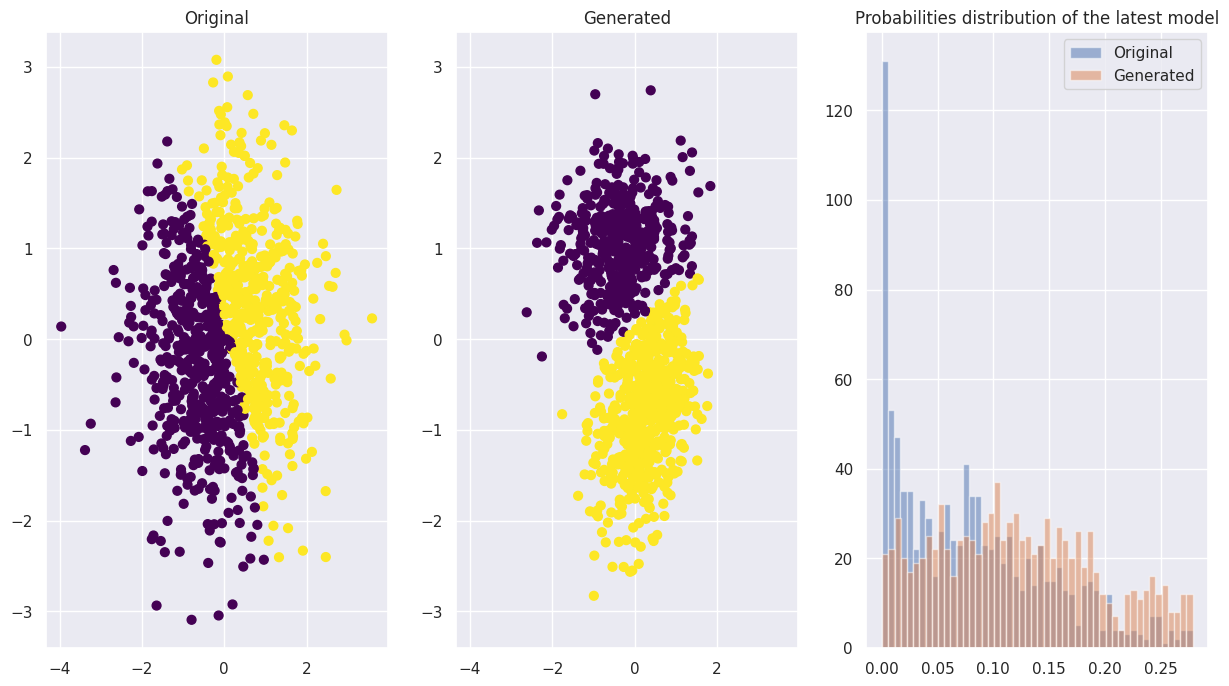

150


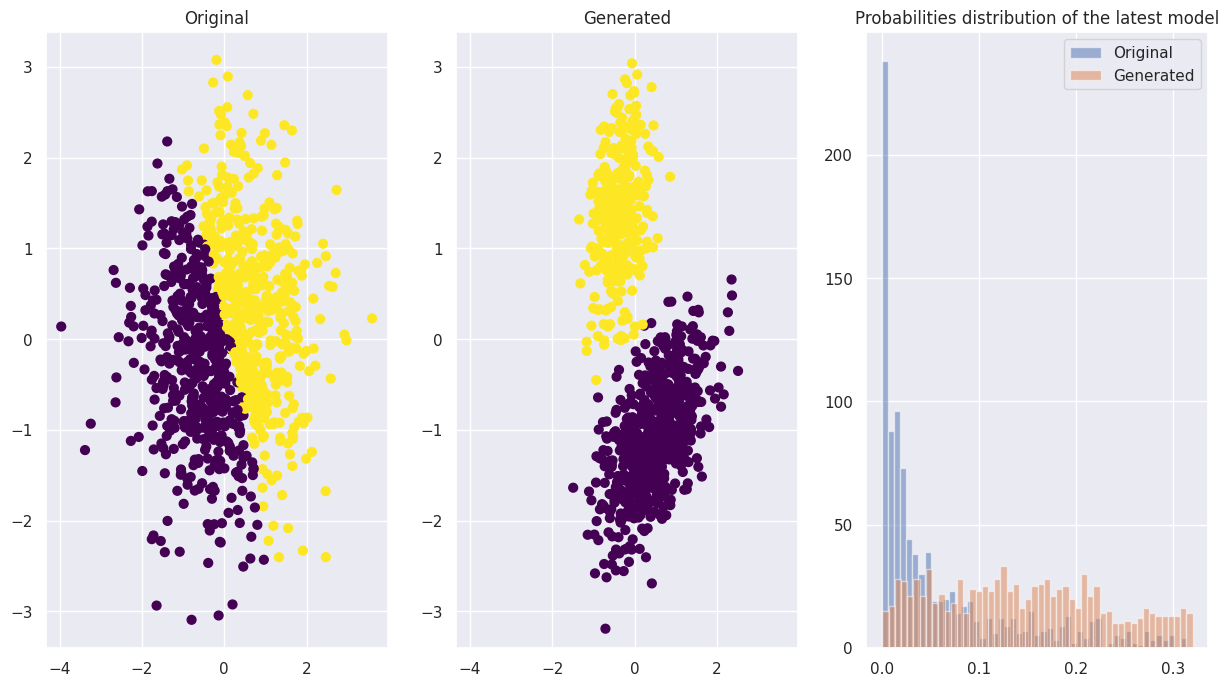

200


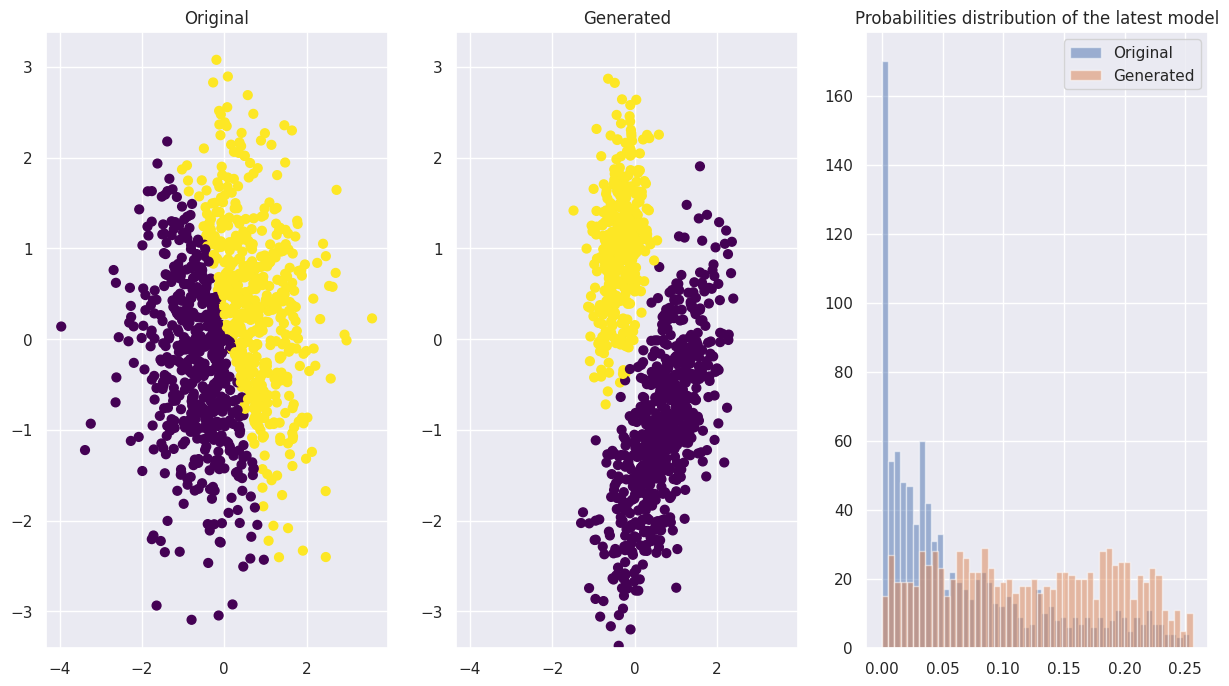

350


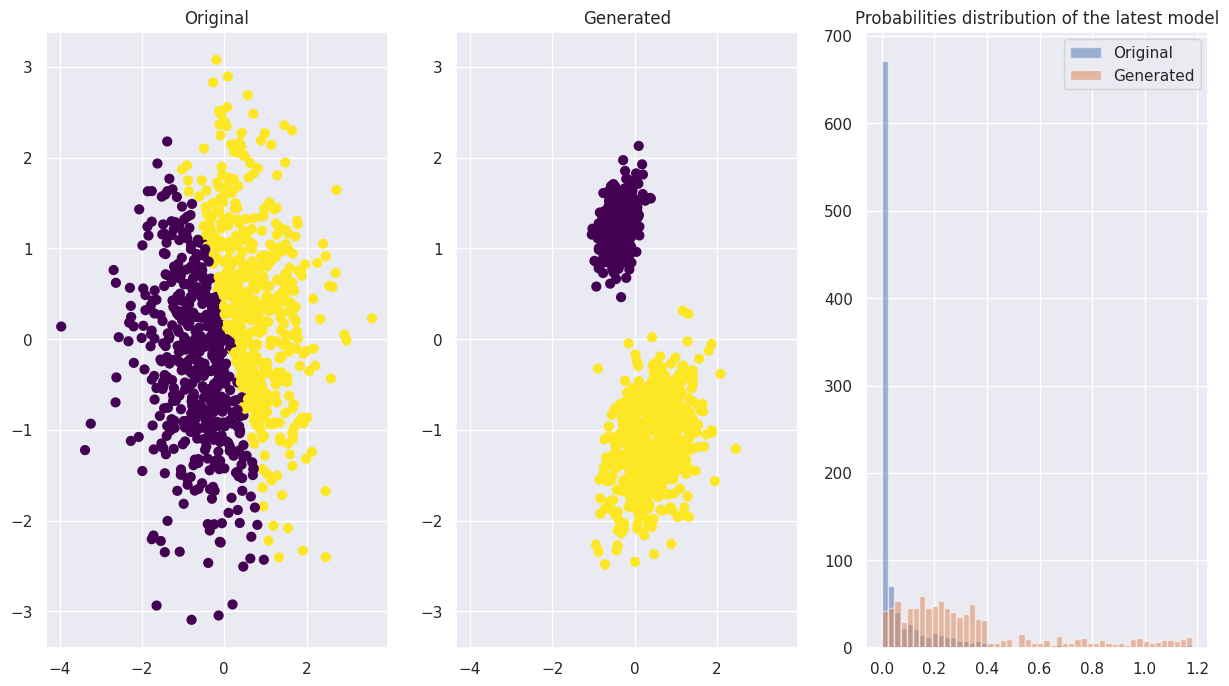

2000


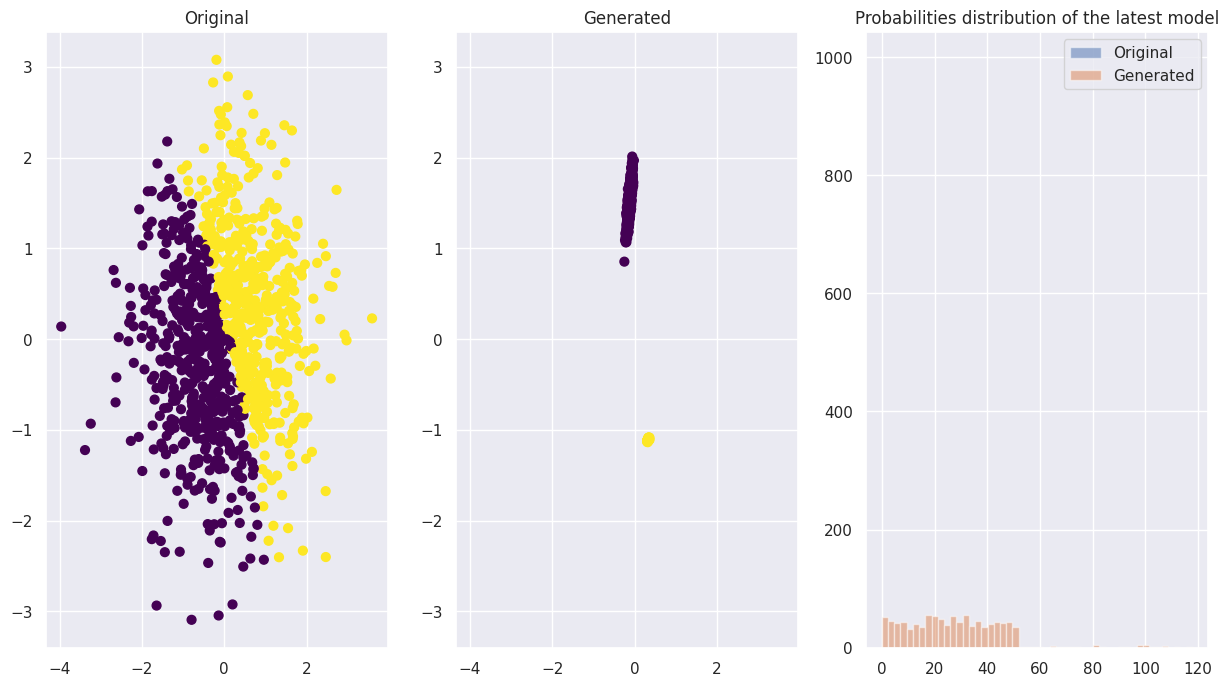

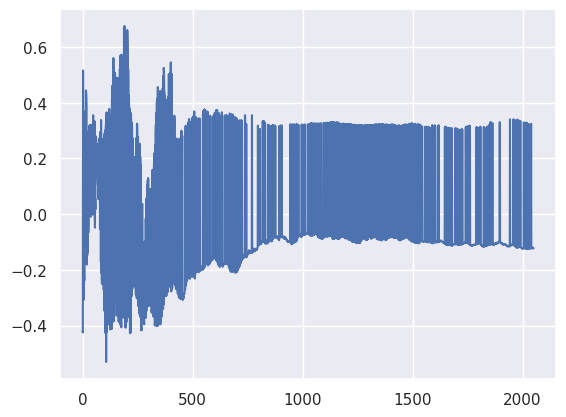

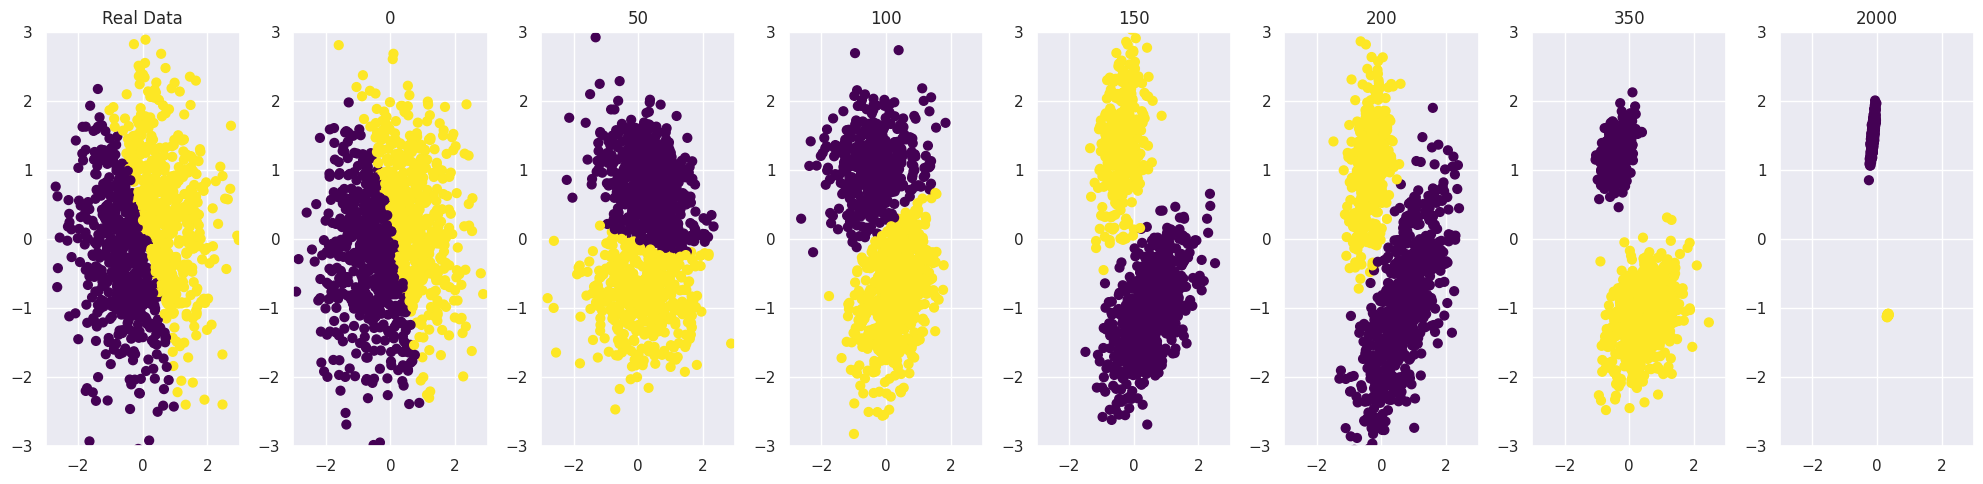

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
from sklearn.datasets import make_blobs
import random

mms = []
ssds = []
vars = [1, ]

ncomponents = 2
gmmparams = {"n_components": ncomponents, "tol": 1e-5, "covariance_type": "full", "max_iter": 2000}

scatters = []
l2s = []
ns = [1000]# [500, 1000, 10000, 50000, 200000]

for var in vars:
  for N in ns:

    # ncomponents
    X, y_true = make_blobs(n_samples=N, n_features=1, centers=[[0,0]], cluster_std=var)

    X0_orig = X[:, ::-1] # flip axes for better plotting
    X_0_gmm = GMM(**gmmparams).fit(X0_orig)
    labels_orig = X_0_gmm.predict(X0_orig)

    X0 = X0_orig[:]
    X = X0[:]


    means = [(X_0_gmm.means_[:].flatten())]
    if gmmparams["covariance_type"]!="diag":
      stds = [([ np.sqrt(  np.trace(X_0_gmm.covariances_[i])/ncomponents) for i in range(0,ncomponents) ])]
    else:
      stds = [X_0_gmm.covariances_]

    # print(means, np.mean(X, axis=1))
    # print(stds,  np.std(X, axis=1))
    evolutions = 2050
    for m in range(evolutions):
      # if m == 0:
        # combined = X0
      # else:
      #   combined = np.vstack([X, X0])
      gmm = GMM(**gmmparams).fit(X)
      
      

      # toadd = random.sample(X0.tolist(), int(len(X0)*1.))
      # X0 = np.vstack([toadd, X0])
      X = gmm.sample(N)[0]

      
      # X = np.vstack([toadd, X])
      l2s.append(L2_of_gmms(X_0_gmm,gmm))
      means.append((gmm.means_[:].flatten()))

      if gmmparams["covariance_type"] != "diag":
        stds.append(([ np.sqrt(  np.trace(gmm.covariances_[i])/ncomponents) for i in range(0,ncomponents) ]))
      else:
        stds.append(gmm.covariances_)
      
      probs_original = np.exp(gmm.score_samples(X0))
      probs_generated = np.exp(gmm.score_samples(X))

      if m in [0, 50, 100, 150, 200, 350, 2000]:
        print(m)
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 8))
        ax[0].scatter(X0_orig[:, 0], X0_orig[:, 1], c=labels_orig, s=40, cmap='viridis');
        ax[0].set_title("Original")
        test = X
        labels = gmm.predict(test)

        scatters.append((test[:,0], test[:, 1], m, labels))
        ax[1].scatter(test[:, 0], test[:, 1], c=labels, s=40, cmap='viridis');
        ax[1].set_ylim(ax[0].get_ylim())
        ax[1].set_xlim(ax[0].get_xlim())
        ax[1].set_title("Generated")
        
        
        ax[2].hist(probs_original, bins=50, alpha=0.5, label='Original')
        ax[2].hist(probs_generated, bins=50, alpha=0.5, label='Generated')
        ax[2].legend()
        ax[2].set_title("Probabilities distribution of the latest model")

        # probs_original = np.exp(X_0_gmm.score_samples(X0))
        # probs_generated = np.exp(X_0_gmm.score_samples(X))
        # ax[3].hist(probs_original, bins=50, alpha=0.5, label='Original')
        # ax[3].hist(probs_generated, bins=50, alpha=0.5, label='Generated')
        # ax[3].legend()
        # ax[3].set_title("Probabilities distribution of the first model")

        # probs_original = gmm.predict_proba(X0)
        # probs_generated = gmm.predict_proba(X)
        # ax[3].hist(probs_original[:, 0], bins=50, alpha=0.5, label='Original')
        # ax[3].hist(probs_generated[:, 0], bins=50, alpha=0.5, label='Generated')
        # ax[3].legend()
        # ax[3].set_title("Probabilities distribution of samples belonging to the first component")
  
        # probs_original = gmm.predict_proba(X0)
        # probs_generated = gmm.predict_proba(X)
        # ax[4].hist(probs_original[:, 1], bins=50, alpha=0.5, label='Original')
        # ax[4].hist(probs_generated[:, 1], bins=50, alpha=0.5, label='Generated')
        # ax[4].legend()
        # ax[4].set_title("Probabilities distribution of samples belonging to the second component")
        plt.show()
    print()

    # Removing all samples with scores in the upper 1 percentile
    # toremove = np.where(probs_generated > np.percentile(probs_generated, 80))[0]
    # X = np.delete(X, toremove, axis=0)

    mms.append(means)
    ssds.append(stds)

    # labels = gmm.predict(X)
    # ax[1].scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')

    plt.figure()
    plt.plot([x[0] for x in means])

fig, ax = plt.subplots(nrows=1, ncols=len(scatters)+1, figsize=(20, 5))
ax[0].scatter(X0_orig[:, 0], X0_orig[:, 1], c=labels_orig, s=40, cmap='viridis')
ax[0].set_title("Real Data")
ax[0].set_ylim([-3,3])
ax[0].set_xlim([-3,3])

for i, (scatx, scaty, epoch, labels) in enumerate(scatters):
  ax[i+1].scatter(scatx, scaty, c=labels, s=40, cmap='viridis')
  ax[i+1].set_title(f"{epoch}")
  ax[i+1].set_ylim(ax[0].get_ylim())
  ax[i+1].set_xlim(ax[0].get_xlim())

plt.tight_layout()

In [10]:

mns = X_0_gmm.means_
cov = X_0_gmm.covariances_
N = ncomponents
sts = [ np.sqrt(  np.trace(cov[i])/ncomponents) for i in range(0,ncomponents) ]
# print(mns, stds)

for (xm, ym), st in zip(mns, sts):
  p99th = xm + st * 2.326
  p97th = xm + st * 1.960
  p95th = xm + st * 1.645
  print(f"Original: 95th {p95th} 97th {p97th} 99th {p97th} mu: {xm} std {st}")


mns = gmm.means_
cov = gmm.covariances_
sts = [ np.sqrt(  np.trace(cov[i])/ncomponents) for i in range(0,ncomponents) ]
# print(mns, stds)


for (xm, ym), st in zip(mns, sts):
  p99th = xm + st * 2.326
  p97th = xm + st * 1.960
  p95th = xm + st * 1.645
  print(f"Last gen: 95th {p95th} 97th {p97th} 99th {p97th} mu: {xm} std {st}")



Original: 95th 1.8966203021787267 97th 2.17235591867609 99th 2.17235591867609 mu: 0.4566676382480522 std 0.8753511634836927
Original: 95th 0.9497731242738111 97th 1.2368372428157097 99th 1.2368372428157097 mu: -0.5493394947783269 std 0.9113146620377738
Last gen: 95th -0.5012491090878035 97th -0.49628145751535496 99th -0.49628145751535496 mu: -0.5271912895217016 std 0.015770322452217662
Last gen: 95th -0.526780902557494 97th -0.5178328721358563 99th -0.5178328721358563 mu: -0.5735095058704913 std 0.028406445782977095


In [11]:
# print(gmm.means_[0],gmm.weights_)
# for (ai,meani,covi),(aj,meanj,covj) in itertools.product(zip(gmm.weights_,gmm.means_,gmm.covariances_),zip(gmm.weights_,gmm.means_,gmm.covariances_)):
#   print(meani-meanj)
print(L2_of_gmms(X_0_gmm,gmm),L2_of_gmms(gmm,X_0_gmm))

125.27160301906862 125.27160301906862


L2s  
--------------------


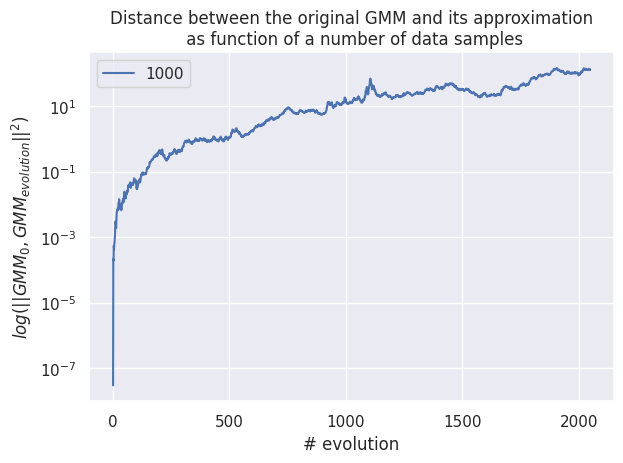

In [12]:
print("L2s  ")
plt.figure()

nn = len(l2s) // len(ns)
for i, var in enumerate(ns):
  _l2 = l2s[i*nn:(i+1)*nn]
  plt.plot(_l2, label=f"{var}")

# for means, var in zip(mms, vars):
  # plt.plot(l2s, label=f"{var}")
# plt.plot([means[0][i] for x in means])
plt.legend()
plt.yscale('log')
plt.xlabel("# evolution")
plt.ylabel("$log(||GMM_0, GMM_{evolution}||^2)$")
plt.title("Distance between the original GMM and its approximation\n as function of a number of data samples")
plt.tight_layout()
# plt.show()
print("--"*10)


# print("Means  ")
# plt.figure()
# for means, var in zip(mms, vars):
#   for i in range(ncomponents*2):
#     plt.plot([x[i] for x in means], label=f"{var}")
#     # plt.plot([means[0][i] for x in means])
# plt.legend()
# plt.xlabel("# evolution")
# plt.ylabel("error")
# plt.title("Mean estimation")
# plt.tight_layout()
# plt.show()
# print("--"*10)

# print("STDs")
# plt.figure()
# for stds, var in zip(ssds, vars):
#   for i in range(ncomponents):
#     plt.plot([x[i] for x in stds], label=f"{var}")
#     # plt.plot([stds[0][i] for x in stds])
# plt.legend()
# plt.tight_layout()
# plt.xlabel("# evolution")
# plt.ylabel("error")
# plt.title("Variance estimation")
# plt.show()

The results for the most part look like plausible digits from the dataset!

Consider what we've done here: given a sampling of handwritten digits, we have modeled the distribution of that data in such a way that we can generate brand new samples of digits from the data: these are "handwritten digits" which do not individually appear in the original dataset, but rather capture the general features of the input data as modeled by the mixture model.
Such a generative model of digits can prove very useful as a component of a Bayesian generative classifier, as we shall see in the next section.

In [13]:
import numpy as np
import sklearn.mixture
from sklearn.mixture import GaussianMixture as GMM
numpoints = [10, 30, 100, 500, 1000, 10000, 100000, 1000000, 10000000]

mu=0.0
sigma=1

mmeans = []
for n in range(1000):
  means = []
  for nump in numpoints:
    # sample data
    a = np.random.normal(mu, sigma, nump)
    # print("mean", np.mean(a), "std", np.std(a)**2, "points", nump)
    means.append(np.std(a))
  # gmm = GMM(tol=1e-30, max_iter=1000000, n_init=30)
  mmeans.append(means)
  # r = gmm.fit(a[:, np.newaxis]) # GMM requires 2D data as of sklearn version 0.16
  # print("mean : %f, var : %f nump : %d" % (r.means_[0, 0], r.covariances_[0, 0], nump))
  # means.append(r.means_[0, 0])


KeyboardInterrupt: 

<>:27: SyntaxWarning: invalid escape sequence '\h'
<>:28: SyntaxWarning: invalid escape sequence '\l'
<>:29: SyntaxWarning: invalid escape sequence '\l'
<>:27: SyntaxWarning: invalid escape sequence '\h'
<>:28: SyntaxWarning: invalid escape sequence '\l'
<>:29: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_761428/2972760278.py:27: SyntaxWarning: invalid escape sequence '\h'
  plt.title("$\hat{\mu}$ estimation of a $\mathcal{N}(\mu=0,\sigma=1)$")
/tmp/ipykernel_761428/2972760278.py:28: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("$\log($number of samples$)$")
/tmp/ipykernel_761428/2972760278.py:29: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel("$\log(|\mu-\hat{\mu}|)$")


[0.91285901 0.97905447 0.99800602 1.00089645 0.99968714 1.00052816
 1.00000541 0.99995147 1.00000309]
[0.21380852 0.13023739 0.06747953 0.03099502 0.02227333 0.00746354
 0.00231005 0.00068412 0.00023073]


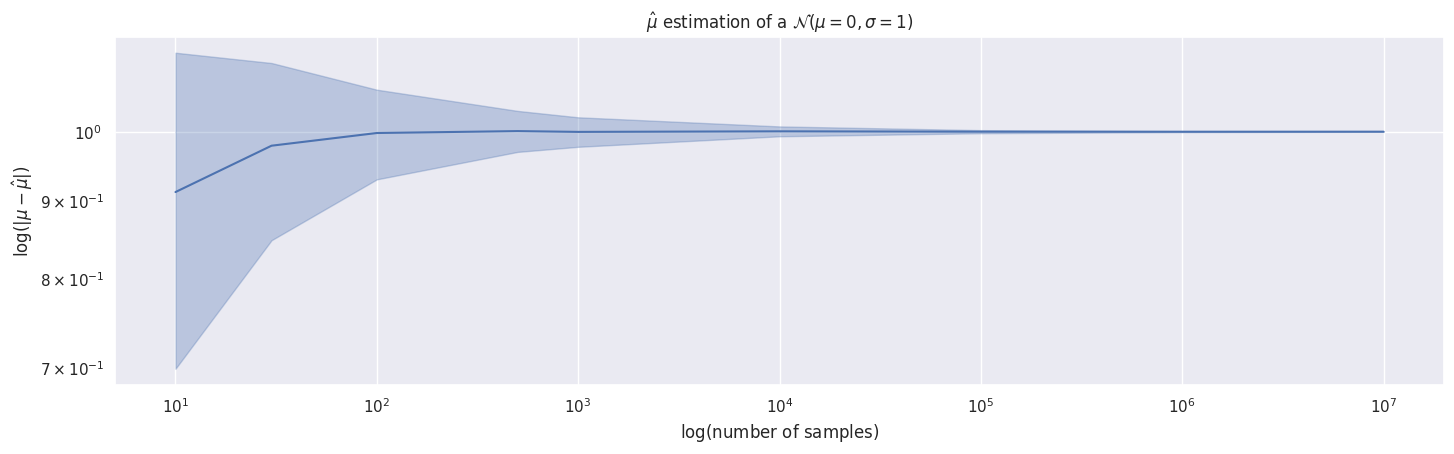

In [14]:
import matplotlib

font = {'size'   : 22}

matplotlib.rc('font', **font)
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

mmm = np.array([np.mean([np.abs(m[i]) for m in mmeans]) for i in range(len(mmeans[0]))])
st = np.array([np.std([np.abs(m[i]) for m in mmeans]) for i in range(len(mmeans[0]))])
print(mmm)
print(st)
p = plt.plot(numpoints, mmm)#, label="estimated $\hat{\mu}$")
plt.fill_between(numpoints, mmm-st, mmm+st, alpha=0.3, color=p[0].get_color())


# for means in mmeans:
  # plt.plot(np.log(np.abs(means)))

# plt.plot(numpoints, [0,]*len(numpoints), label="true $\mu$")

plt.xscale('log')
plt.yscale('log')
# plt.yscale('symlog')

plt.title("$\hat{\mu}$ estimation of a $\mathcal{N}(\mu=0,\sigma=1)$")
plt.xlabel("$\log($number of samples$)$")
plt.ylabel("$\log(|\mu-\hat{\mu}|)$")
# plt.legend()
plt.tight_layout()


In [15]:
import numpy as np
import sklearn.mixture
from sklearn.mixture import GaussianMixture as GMM

numpoints = [100, 500, 1000, 10000,]# 100000, 1000000, 10000000]

truemu=0.0
truesigma=1
evols = 1000

mmeans = []
mstds  = []
for nump in numpoints:
  means = []
  stds = []
  mu=truemu
  sigma=truesigma
  for n in range(evols):
    # print(nump, n, truesigma, sigma)
    a = np.random.normal(mu, sigma, nump)
    hatmu = np.mean(a)
    hatsigma = np.std(a)
    means.append(hatmu)
    stds.append(hatsigma)
    mu = hatmu
    sigma = hatsigma

  mmeans.append(means)
  mstds.append(stds)



<>:12: SyntaxWarning: invalid escape sequence '\h'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\h'
<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\h'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\h'
<>:27: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_761428/1765355267.py:12: SyntaxWarning: invalid escape sequence '\h'
  plt.title("$\hat{\mu}$ estimation of a $\mathcal{N}(\mu=0,\sigma=1)$")
/tmp/ipykernel_761428/1765355267.py:14: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$|\mu-\hat{\mu}|$")
/tmp/ipykernel_761428/1765355267.py:25: SyntaxWarning: invalid escape sequence '\h'
  plt.title("$\hat{\sigma}$ estimation of a $\mathcal{N}(\mu=0,\sigma=1)$")
/tmp/ipykernel_761428/1765355267.py:27: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("$|\sigma-\hat{\sigma}|$")


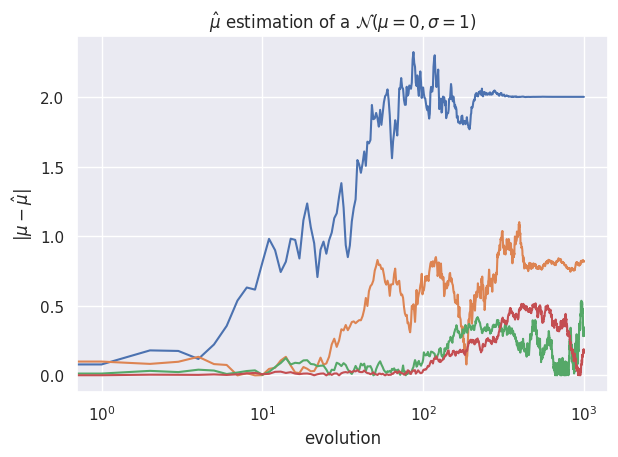

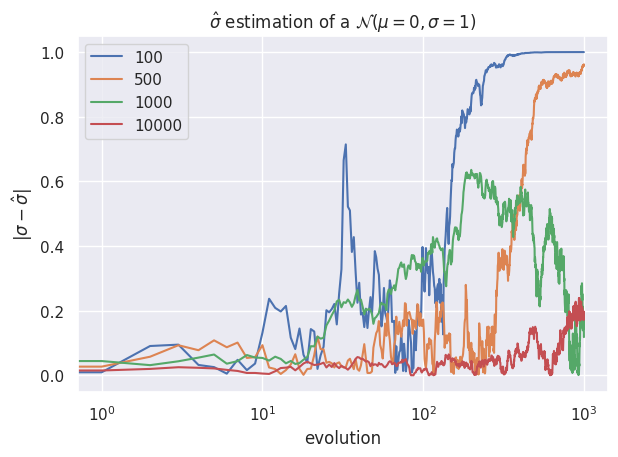

In [17]:
import matplotlib

font = {'size'   : 14}
matplotlib.rc('font', **font)
import matplotlib.pyplot as plt

plt.figure()

for m, nump in zip(mmeans, numpoints):
  plt.plot(range(len(m)), np.abs(np.array(m)-truemu), label = f"{nump}")

plt.title("$\hat{\mu}$ estimation of a $\mathcal{N}(\mu=0,\sigma=1)$")
plt.xlabel("evolution")
plt.ylabel("$|\mu-\hat{\mu}|$")
plt.xscale('log')
# plt.yscale('log')
# plt.legend()
plt.tight_layout()


plt.figure()
for m, nump in zip(mstds, numpoints):
  plt.plot(range(len(m)), np.abs(np.array(m)-truesigma), label = f"{nump}")

plt.title("$\hat{\sigma}$ estimation of a $\mathcal{N}(\mu=0,\sigma=1)$")
plt.xlabel("evolution")
plt.ylabel("$|\sigma-\hat{\sigma}|$")
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.tight_layout()


Now lets consider the case where data gets saved over time and not thrown away

In [18]:
import numpy as np
import sklearn.mixture
from sklearn.mixture import GaussianMixture as GMM

numpoints = [100, 500, 1000, 10000,]# 100000, 1000000, 10000000]

truemu=0.0
truesigma=1
evols = 1000

mmeans = []
mstds  = []
for nump in numpoints:
  means = []
  stds = []
  mu=truemu
  sigma=truesigma
  a = []
  for n in range(evols):
    # print(nump, n, truesigma, sigma)
    aa = np.random.normal(mu, sigma, nump)
    a.extend(aa)
    hatmu = np.mean(a)
    hatsigma = np.std(a)
    means.append(hatmu)
    stds.append(hatsigma)
    mu = hatmu
    sigma = hatsigma

  mmeans.append(means)
  mstds.append(stds)



In [ ]:
import matplotlib

font = {'size'   : 14}
matplotlib.rc('font', **font)
import matplotlib.pyplot as plt

plt.figure()

for m, nump in zip(mmeans, numpoints):
  plt.plot(range(len(m)), np.abs(np.array(m)-truemu), label = f"{nump}")

plt.title("$\hat{\mu}$ estimation of a $\mathcal{N}(\mu=0,\sigma=1)$")
plt.xlabel("evolution")
plt.ylabel("$|\mu-\hat{\mu}|$")
plt.xscale('log')
# plt.yscale('log')
# plt.legend()
plt.tight_layout()

plt.figure()

for m, nump in zip(mstds, numpoints):
  plt.plot(range(len(m)), np.abs(np.array(m)-truesigma), label = f"{nump}")

plt.title("$\hat{\sigma}$ estimation of a $\mathcal{N}(\mu=0,\sigma=1)$")
plt.xlabel("evolution")
plt.ylabel("$|\sigma-\hat{\sigma}|$")
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.tight_layout()
